<a href="https://colab.research.google.com/github/spatank/CIS-521/blob/master/Homework%206/spp_text_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
root_directory = 'drive/Shared drives/cis530_hw6/data'
!ls 'drive/Shared drives/cis530_hw6/data'

eng-fra.txt  names


In [6]:
!ls 'drive/Shared drives/cis530_hw6/data/names'

Arabic.txt   English.txt  Irish.txt	Polish.txt	Spanish.txt
Chinese.txt  French.txt   Italian.txt	Portuguese.txt	Vietnamese.txt
Czech.txt    German.txt   Japanese.txt	Russian.txt
Dutch.txt    Greek.txt	  Korean.txt	Scottish.txt


In [8]:
!ls

drive  sample_data


In [9]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles(root_directory + '/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
      )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in findFiles(root_directory + '/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines # maps each category (language) to list of names
  
n_categories = len(all_categories)

['drive/Shared drives/cis530_hw6/data/names/Arabic.txt', 'drive/Shared drives/cis530_hw6/data/names/Chinese.txt', 'drive/Shared drives/cis530_hw6/data/names/Irish.txt', 'drive/Shared drives/cis530_hw6/data/names/Czech.txt', 'drive/Shared drives/cis530_hw6/data/names/German.txt', 'drive/Shared drives/cis530_hw6/data/names/Dutch.txt', 'drive/Shared drives/cis530_hw6/data/names/English.txt', 'drive/Shared drives/cis530_hw6/data/names/Italian.txt', 'drive/Shared drives/cis530_hw6/data/names/French.txt', 'drive/Shared drives/cis530_hw6/data/names/Greek.txt', 'drive/Shared drives/cis530_hw6/data/names/Japanese.txt', 'drive/Shared drives/cis530_hw6/data/names/Scottish.txt', 'drive/Shared drives/cis530_hw6/data/names/Vietnamese.txt', 'drive/Shared drives/cis530_hw6/data/names/Portuguese.txt', 'drive/Shared drives/cis530_hw6/data/names/Spanish.txt', 'drive/Shared drives/cis530_hw6/data/names/Korean.txt', 'drive/Shared drives/cis530_hw6/data/names/Polish.txt', 'drive/Shared drives/cis530_hw6/dat

In [12]:
category_lines['Italian'][:5]

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']

In [13]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
  return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [0]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)
    
  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden
    
  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [0]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

In [30]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9194, -2.9939, -2.8533, -2.8889, -2.8731, -2.8679, -2.7746, -2.9989,
         -2.8631, -2.8885, -2.9084, -2.9104, -2.9424, -2.8849, -2.8592, -2.8285,
         -2.8913, -2.9040]], grad_fn=<LogSoftmaxBackward>)


In [31]:
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

print(categoryFromOutput(output))

('English', 6)


In [32]:
import random

def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('category =', category, '/ line =', line)

category = Japanese / line = Matsumoto
category = English / line = Small
category = French / line = Brisbois
category = Scottish / line = Stevenson
category = Arabic / line = Sabbag
category = Scottish / line = Mackay
category = Polish / line = Niemec
category = Russian / line = Velikson
category = Dutch / line = Reynder
category = Chinese / line = Hor


In [0]:
criterion = nn.NLLLoss()

In [0]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()

  rnn.zero_grad()
  
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
    
  loss = criterion(output, category_tensor)
  loss.backward()
  
  # Add parameters' gradients to their values, multiplied by learning rate
  for p in rnn.parameters():
    p.data.add_(-learning_rate, p.grad.data)
    
  return output, loss.item()

In [35]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss
  
  # Print iter number, loss, name and guess
  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = '✓' if guess == category else '✗ (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
    
  # Add current loss avg to list of losses
  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5000 5% (0m 7s) 2.7019 Asker / German ✗ (Arabic)
10000 10% (0m 14s) 1.7073 Moon / Korean ✓
15000 15% (0m 21s) 1.4144 Vo / Vietnamese ✓
20000 20% (0m 28s) 2.3255 Reijnder / French ✗ (Dutch)
25000 25% (0m 35s) 1.9469 Lilwall / Irish ✗ (English)
30000 30% (0m 42s) 0.8992 Hong / Chinese ✗ (Korean)
35000 35% (0m 49s) 1.0467 Starek / Polish ✓
40000 40% (0m 56s) 1.0488 Hadjiyianakies / Greek ✓
45000 45% (1m 3s) 2.1585 Nowell / Polish ✗ (English)
50000 50% (1m 11s) 1.6834 Obando / Italian ✗ (Spanish)
55000 55% (1m 18s) 3.4457 Fox / Korean ✗ (English)
60000 60% (1m 25s) 1.5352 Shiganori / Italian ✗ (Japanese)
65000 65% (1m 32s) 2.4416 Yoman / Arabic ✗ (English)
70000 70% (1m 39s) 2.0293 Vieth / Dutch ✗ (German)
75000 75% (1m 46s) 1.6881 O'Callaghann / Dutch ✗ (Irish)
80000 80% (1m 53s) 2.5664 Geier / German ✗ (Czech)
85000 85% (2m 0s) 1.8348 Faucher / Irish ✗ (French)
90000 90% (2m 7s) 0.6677 Gaber / Arabic ✓
95000 95% (2m 15s) 0.1062 Higoshi / Japanese ✓
100000 100% (2m 22s) 2.3645 Tillens / E

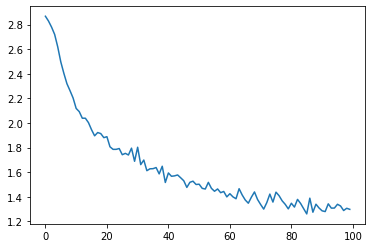

In [36]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

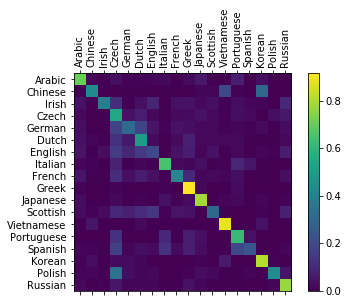

In [38]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
  hidden = rnn.initHidden()
  
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
    
  return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = categoryFromOutput(output)
  category_i = all_categories.index(category)
  confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
  confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [39]:
def predict(input_line, n_predictions=3):
  print('\n> %s' % input_line)
  with torch.no_grad():
    output = evaluate(lineToTensor(input_line))
    
    # Get top N categories
    topv, topi = output.topk(n_predictions, 1, True)
    predictions = []
    
    for i in range(n_predictions):
      value = topv[0][i].item()
      category_index = topi[0][i].item()
      print('(%.2f) %s' % (value, all_categories[category_index]))
      predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.70) Czech
(-0.75) Russian
(-4.35) Greek

> Jackson
(-1.16) Russian
(-1.52) English
(-1.52) Scottish

> Satoshi
(-0.77) Arabic
(-1.03) Japanese
(-2.55) Italian
